---
title: Ejercicio 21
lang: es
documentclass: scrreprt
papersize: A4
classoption: []
execute:
    echo: False
toc: true
format:
    html:
        theme: cosmo
        embed-resources: true
        fig-responsive: true
        html-math-method: mathjax
    pdf:
        df-print: tibble
        include-in-header:
          text: |
            \usepackage{scrlayer-scrpage}
            \clearpairofpagestyles  % Correct command for KOMA
            \ofoot{\pagemark}
            \usepackage{geometry}
        geometry:
            - top=20mm
            - bottom=20mm
            - left=10mm
            - right=10mm
            - marginparsep=10mm     
warning: false
message: false
jupyter: python3
---

## Enunciado

> Supongamos un proyecto para pintar la fachada de un edificio de planta cuadrada. Cada fachada se estima que tarde dos días en pintarse y conlleve un gasto de 2000 euros. Las fachadas se pintan consecutivamente. Hoy es el final del día 6 y el trabajo se encuentra de la siguiente manera:
>    - Fachada 1: Acabado en el día 2, 2000 euros.
>    - Fachada 2: Acabado en el día 5, 2400 euros.
>    - Fachada 3: 50% acabado, 1200 euros.
>    - Fachada 4: sin empezar.
>     
> El coste final estimado por el contratista, LRE, es de 8200 euros.
> Se pide realizar un analisis del valor ganado del proyecto a fecha actual (fin del día 6). Se admite un error de precisión de 0.02.
> De las fórmulas estudiadas para el coste estimado final por el promotor utilice: EAC=BAC/CPI.


In [54]:
from jupyter_tikz import TexFragment
from IPython.display import Latex, Markdown, Math
import handcalcs.render
from handcalcs import handcalc

#%pip install handcalcs

In [3]:
"""
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"


if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files
"""
import os, sys

# To find local version of the library
sys.path.append('pmULE/src')

from pmule import PredecessorTable, ProjectGraph, EarnedValue

In [4]:
# Alargamos el ancho de las celdas al 100%
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import numpy as np

datos_enunciado = pd.DataFrame([
#     actividad,   precedentes,  duracion,  coste_planificado,     coste_real,  duracion_real,  realizado
     ('Fachada·1', '---      ',       2,            2000,              2000,          2,       100,   ),
     ('Fachada·2', 'Fachada·1',       2,            2000,              2400,          3,       100,   ),
     ('Fachada·3', 'Fachada·2',       2,            2000,              1200,          1,        50,   ),
     ('Fachada·4', 'Fachada·3',       2,            2000,                 0,          0,           0,   ),
] ,columns=['actividad', 'precedentes', 'duracion',  'coste_planificado', 'coste_real', 'duracion_real',
            'realizado']).set_index('actividad')
datos_enunciado

,precedentes,duracion,coste_planificado,coste_real,duracion_real,realizado
actividad,,,,,,
Fachada·1,---,2,2000,2000,2,100
Fachada·2,Fachada·1,2,2000,2400,3,100
Fachada·3,Fachada·2,2,2000,1200,1,50
Fachada·4,Fachada·3,2,2000,0,0,0


### Resolución


In [5]:
datos_proyecto=datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='actividad', predecessor='precedentes')
prelaciones.display_immediate_linkage_matrix()

,Fachada·1,Fachada·2,Fachada·3,Fachada·4
activities,,,,
Fachada·1,,,,
Fachada·2,True,,,
Fachada·3,,True,,
Fachada·4,,,True,


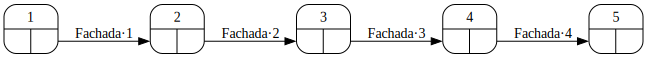

In [6]:
proyecto = prelaciones.create_project()
proyecto.pert()

#### Gantt Valor Planificado

In [7]:
vg = EarnedValue(proyecto)

In [8]:
datos_proyecto['duracion'] = datos_proyecto['duracion'].astype(float)
gantts = vg.calcula_gantts(data=datos_proyecto,
                           planned_durations_label = 'duracion',
                           actual_durations_label='duracion_real',
                           PV_label='coste_planificado',
                           AC_label='coste_real',
                           percentage_complete_label='realizado',
                           tikz=True,
                           params=dict(
                               period_width=2,
                           )
                          )

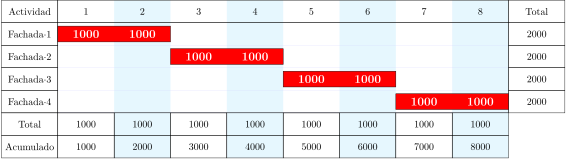

In [9]:
os.chdir("/Users/mcasl/temp")
TexFragment(gantts['gantt_PV']).run_latex()

#### Gantt Valor Ganado

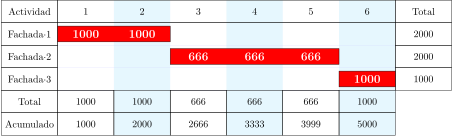

In [10]:
TexFragment(gantts['gantt_EV']).run_latex()

#### Gantt Coste Real

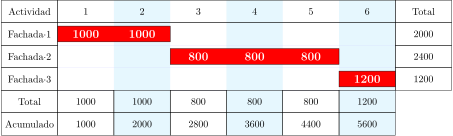

In [11]:
TexFragment(gantts['gantt_AC']).run_latex()

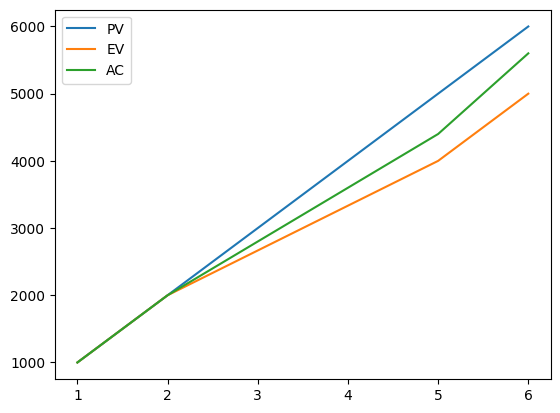

In [12]:
acumulados = gantts['acumulados']
acumulados.plot();

In [13]:
acumulados.tail(1)

,PV,EV,AC
6,6000.0,5000.0,5600.0


#### Cálculo de parámetros diversos

In [14]:
EV = acumulados.tail(1)['EV'].iloc[0]
AC = acumulados.tail(1)['AC'].iloc[0]
PV = acumulados.tail(1)['PV'].iloc[0]

In [15]:
BAC = int(datos_enunciado.loc[:, 'coste_planificado'].sum())

In [16]:
Markdown(f"""Utilizando: \\
PV={PV} \\
AC={AC} \\
EV={EV} \\
y el BAC={BAC} obtenido sumando los costes planificados, obtenemos:
""")

Utilizando: \
PV=6000.0 \
AC=5600.0 \
EV=5000.0 \
y el BAC=8000 obtenido sumando los costes planificados, obtenemos:


In [56]:
from handcalcs.decorator import handcalc

@handcalc(jupyter_display=False) 
def my_calculation(EV,AC,PV,BAC):
    CPI = EV/AC
    SPI = EV/PV
    EAC = BAC / CPI
    CV = EV - AC
    CV_relativo = CV/EV *100
    SV = EV - PV
    SV_relativo = SV/PV *100
    VAC = BAC - EAC
    PC = EV / BAC
    PS = AC / BAC
    PP = PV / BAC
    TCPI_BAC = (BAC - EV)/(BAC - AC)
    TCPI_EAC = (BAC - EV)/(EAC - AC)
    LRE = 8200
    TCPI_LRE = (BAC - EV)/(LRE - AC)
latex_code, _ = my_calculation(EV,AC,PV,BAC)
Math((latex_code))

<IPython.core.display.Math object>

La diferencia de rendimiento en costes indica que el LRE proporcionado no es verosimil.